In [1]:
from trendAnalyserPy import StockTrendAnalyzer
from backtestPy import Backtester
from optimizerPy import Optimizer
import yfinance as yf
import numpy as np
import pandas as pd

In [7]:
class Trading:
    def __init__(self, symbol, start_date, end_date, interval, period=None):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.period = period

        # Initialize the detector with properly loaded data
        self.stock = self._load_data()
        self.detector = StockTrendAnalyzer(symbol, start_date, end_date, self.stock, interval, period)
        self.backtester = Backtester(symbol, start_date, end_date, interval, self.stock)
        self.optimizer = Optimizer(self.backtester)

        self.peaks = []
        self.throughs = []
        self.uptrends = []
        self.downtrends = []
        

    def _load_data(self):
        """
        Load stock data, considering intraday intervals with period and start_date.
        """
        if self.interval in ['1m', '2m', '5m', '15m', '30m', '60m', '90m']:  # Intraday intervals
            stock = yf.download(self.symbol, period=self.period, interval=self.interval)
            stock.reset_index(inplace=True)
            stock.rename(columns={'Datetime': 'Date'}, inplace=True)
            
            # Filter by start_date
            stock['Date'] = pd.to_datetime(stock['Date'])
            stock = stock[stock['Date'] >= pd.to_datetime(self.start_date)]
        else:  # Daily or higher intervals
            stock = yf.download(self.symbol, start=self.start_date, end=self.end_date, interval=self.interval)
            #stock.columns = stock.columns.droplevel(1)

        print("Data loaded successfully.")
        return stock

    def analyze_stock(self):
        """
        Analyze stock trends for the initialized symbol and time period.
        """
        analyzer = self.detector
        analyzer.data = self.stock  # Ensure detector works with the loaded data
        self.peaks, self.troughs = analyzer.find_peaks_and_troughs()
        self.uptrends, self.downtrends = analyzer.identify_trends()
        
        # Generate visualization
        #plt = analyzer.visualize_trends()
        #plt.show()
        
        # Print trend summary
        print(f"\nTrend Summary for {self.symbol}:")
        for summary in analyzer.get_trend_summary():
            print(summary)
        
        return analyzer

    def analyze_and_backtest(self, analyzer, strategy=None, **kwargs):
        """
        Perform analysis to find peaks and troughs, and then backtest using the results.
        """
        # Step 1: Analyze data to find peaks and troughs
        peaks = analyzer.peaks
        troughs = analyzer.troughs
        uptrends = analyzer.uptrends
        downtrends = analyzer.downtrends
    
        # Step 2: Update params with peaks and troughs
        params = {}
        params["peaks"] = peaks
        params["troughs"] = troughs
        params["uptrends"] = uptrends
        params["downtrends"] = downtrends
    
        # Step 3: Initialize Backtester with data and params
        backtester = Backtester(
            symbol=self.symbol,
            start_date=self.start_date,
            end_date=self.end_date,
            interval=self.interval,
            data=self.stock,
            initial_capital=10000,
            strategy=strategy,
            **params
        )
    
        # Step 4: Run the backtest and return results
        results = backtester.backtest(strategy, **kwargs)
        plt = backtester.visualize_data()
        plt.show()
        if results is not None:
            backtester.print_results(results)
        return backtester
        
    def optimize(self, strategy, param_ranges, initial_guess):
        """
        Optimize trading strategy parameters.
        """
        backtester = Backtester(self.stock)
        optimizer = Optimizer(backtester)
        return optimizer.optimize(strategy, param_ranges, initial_guess)


[*********************100%%**********************]  1 of 1 completed


Data loaded successfully.

Trend Summary for SPY:
Uptrend: Start: 2024-02-27 (Price: $506.93), End: 2024-03-08 (Price: $511.72), Change: 0.9%
Downtrend: Start: 2024-02-16 (Price: $499.51), End: 2024-02-22 (Price: $507.50), Change: 1.6%
No Trades in between these dates
None


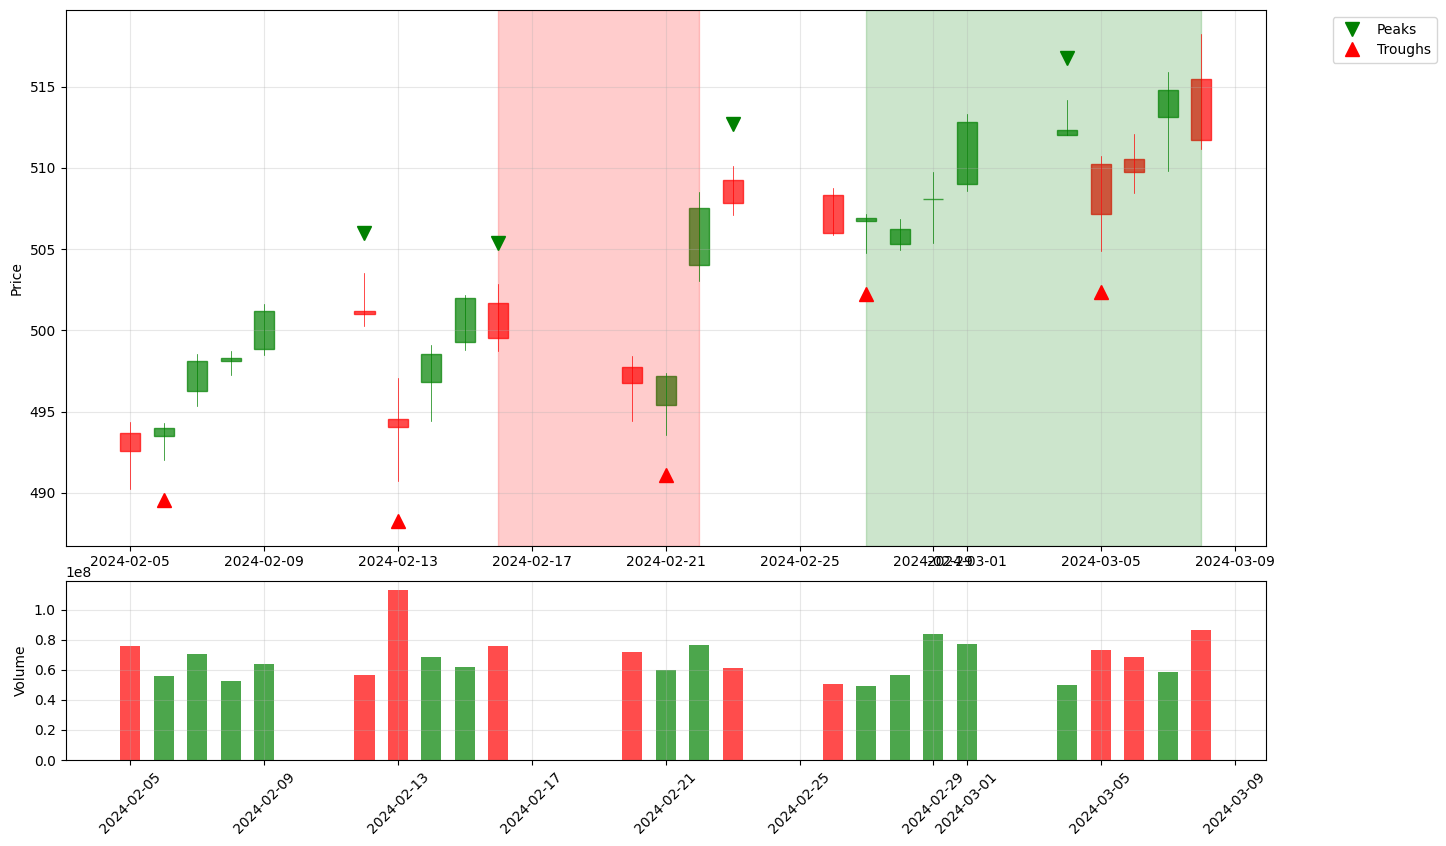

In [8]:
symbol='SPY'
start_date='2024-02-03' 
end_date='2024-03-10'
period='1d'
interval='1d'
trading = Trading(symbol, start_date, end_date, interval=interval, period=period)
analyzer = trading.analyze_stock()
#backtest = trading.analyze_and_backtest(analyzer)
backtest = trading.analyze_and_backtest(analyzer, strategy=sma_crossover_strategy, sma_s=5, sma_l=20, take_profit=0.03, stop_loss=0.02)

In [3]:
def sma_crossover_strategy(data: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Simple Moving Average (SMA) crossover strategy for long positions only.
    Generates buy signals when short-term SMA crosses above long-term SMA,
    and exit signals when short-term SMA crosses below long-term SMA.
    
    Args:
        data (pd.DataFrame): DataFrame with OHLCV data
        **kwargs: Strategy parameters including:
            - sma_s (int): Short-term SMA period (default: 20)
            - sma_l (int): Long-term SMA period (default: 50)
            - take_profit (float): Take profit percentage (default: None)
            - stop_loss (float): Stop loss percentage (default: None)
    
    Returns:
        pd.DataFrame: DataFrame with Position column (0 for no position, 1 for long)
    """
    # Get parameters from kwargs with defaults
    sma_s = kwargs.get('sma_s', 20)
    sma_l = kwargs.get('sma_l', 50)
    
    # Calculate SMAs
    data['SMA_Short'] = data['Close'].rolling(window=sma_s).mean()
    data['SMA_Long'] = data['Close'].rolling(window=sma_l).mean()
    
    # Initialize position column
    data['Position'] = 0
    
    # Generate signals
    # Long entry signal: Short SMA crosses above Long SMA
    data.loc[data['SMA_Short'] > data['SMA_Long'], 'Position'] = 1
    
    # Exit signal: Short SMA crosses below Long SMA
    data.loc[data['SMA_Short'] < data['SMA_Long'], 'Position'] = 0
    
    # Fill NaN values with 0
    data['Position'] = data['Position'].fillna(0)
    
    # Return DataFrame with Position column
    return data[['Position']]

# Add name attribute for strategy identification
sma_crossover_strategy._name_ = 'Long_Only_SMA_Crossover'

In [6]:
backtest.get_trades_info()

,type,entry_price,exit_price,entry_idx,exit_idx,profit_percent,profit_money,open_date,close_date
0,long,472.290009,513.070007,9,63,8.634525,863.452498,2024-01-17,2024-04-04
1,short,505.410004,508.260010,77,79,-0.563900,-56.389982,2024-04-24,2024-04-26
2,long,505.029999,525.960022,83,98,4.144313,414.431286,2024-05-02,2024-05-23
3,long,544.830017,541.229980,119,139,-0.660763,-66.076327,2024-06-25,2024-07-24
4,long,558.299988,552.080017,164,167,-1.114091,-111.409114,2024-08-28,2024-09-03
5,long,568.250000,568.640015,180,209,0.068634,6.863434,2024-09-20,2024-10-31
6,long,585.750000,607.809998,220,234,3.766111,376.611141,2024-11-15,2024-12-06
